In [5]:
%load_ext autoreload
%autoreload 2
from City import *
from Mass import *
import mplleaflet_custom as mplleaflet
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
from scipy.spatial import distance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
Hamburg = City(53.5488, 9.9872, 0.3, 0.5)

In [3]:
mass = Mass()
mass.load_json_file('cm_logs/20220624/20220624_214724.txt')
plt.plot(mass.get_long(),mass.get_lat(),'b.')
mplleaflet.display()

c:\Users\Hauke\critical_length\.venv\Lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [6]:
mass.remove_points_outside_window(Hamburg.get_window())
mass.remove_points_outside_circle(Hamburg.get_center(),20)
plt.plot(mass.get_long(),mass.get_lat(),'b.')
mplleaflet.display()

c:\Users\Hauke\critical_length\.venv\Lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [23]:
def get_train_indices(mass,subset=':',debug=0,n_next=5,crit_thr=6):
    if subset==':':
        subset = np.full(len(mass.positions),True)
    positions = mass.positions[subset]
    # Calculate distance maps, using geopy gedoesic as custom distance function
    # see https://stackoverflow.com/questions/31632190/measuring-geographic-distance-with-scipy
    # VERY costly function because geopy_distance.geodesic is slow
    D = distance.squareform(distance.pdist(positions, lambda u, v: geopy_distance.great_circle(u,v).m))
    closest = np.argsort(D, axis=1) #each line represents closest point indices
    crit = np.mean(np.sort(D,axis=1)[:,1:n_next+1],axis=1)
    if debug:
        counts,edges = np.histogram(crit,bins=101)
        plt.stairs(counts,edges,fill=True)
        plt.show()
        plt.figure(figsize=(6,6))
        print('Median:',np.median(crit))
    selec = crit<crit_thr*np.median(crit)
    # Return point list and distance matrix because it is computationally expensive to calculate
    return np.where(selec)[0], D # return indices where criterion is True
    # subset_train = np.full(len(mass.positions),False);
    # for ii,s in enumerate(subset):
    #     if s:
    #         subset_train[ii] = selec[sum(subset[0:ii])]
    # return subset_train,positions[selec],D[np.ix_(selec,selec)]

idx_train,D=get_train_indices(mass,n_next=5,crit_thr=4,debug=0)
plt.plot(mass.get_long(),mass.get_lat(),'xr')
plt.plot(mass.get_long()[idx_train],mass.get_lat()[idx_train], 'ob', ms=3, mew=2)
plt.plot(mass.get_long()[2],mass.get_lat()[2], 'ob', ms=10, mew=2);
mplleaflet.display()

c:\Users\Hauke\critical_length\.venv\Lib\site-packages\IPython\core\display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


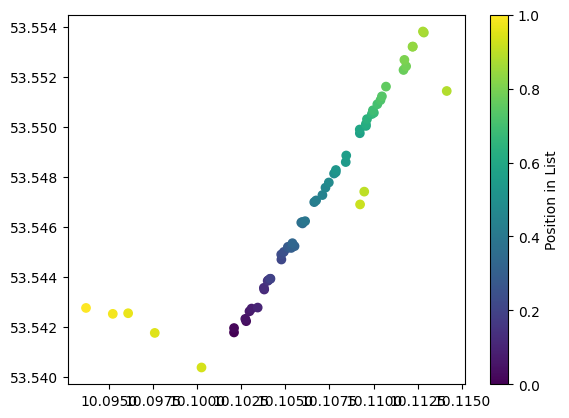

In [ ]:
# Probably better:
# https://de.wikipedia.org/wiki/Dichtestes_Punktpaar
# Actually it is the traveling salesman problem

 
def find_starting_point_idx(mass,subset):
    # Find outermost point with the largest distance to the mean of all points
    positions = mass.positions[subset]
    mean = np.median(positions,axis=0)
    #print(mean)
    dist_to_mean = [geopy_distance.great_circle(p,mean).m for p in positions]
    return subset[np.argmax(dist_to_mean)]
    
def sort_points(mass,D,subset): 
    closest1_avg = np.argsort(D, axis=1) #each line represents closest point indices
    # Reorder points according to closest points (second column in closest1_avg, first column points to point itself)
    sorted_points_idx = []
    next_point = find_starting_point_idx(mass,subset) # can fail
    # Greedy algorithm first round
    for _ in range(0,len(subset)):
        sorted_points_idx.append(next_point)
        ii_neighbor = 0
        while len(sorted_points_idx) < len(subset) and next_point in sorted_points_idx:
            idx_neighbor = subset[ii_neighbor]
            next_point = closest1_avg[sorted_points_idx[-1],idx_neighbor] # Check neighbors of last point
            ii_neighbor = ii_neighbor + 1
    positions = mass.positions[sorted_points_idx]
    # Find largest distance in train + distance between supposed starting point and final point
    distances = [geopy_distance.great_circle(positions[0],positions[-1]).m]
    distances.extend([geopy_distance.great_circle(u,v).m for u,v in zip(positions[:-1],positions[1:])])
    idx_maximum_distance = sorted_points_idx[np.argmax(distances)] #is 0 if largest distance between current start and end point
    if idx_maximum_distance!=sorted_points_idx[0]:
        sorted_points_idx = np.int64(np.concatenate((np.flip(sorted_points_idx[idx_maximum_distance:]),sorted_points_idx[0:idx_maximum_distance])))
    # Greedy algorithm second round backwards
    next_point = sorted_points_idx[-1]
    sorted_points_idx_new = []
    # Greedy algorithm second round -> removes any remaining turn in loop
    for _ in range(0,len(sorted_points_idx)):
        sorted_points_idx_new.append(next_point)
        ii_neighbor = 0
        while len(sorted_points_idx_new) < len(subset) and next_point in sorted_points_idx_new:
            idx_neighbor = subset[ii_neighbor]
            next_point = closest1_avg[sorted_points_idx_new[-1],ii_neighbor] # Check neighbors of last point
            ii_neighbor = ii_neighbor + 1
    sorted_points_idx = sorted_points_idx_new;    
    return sorted_points_idx

idx_sorted = sort_points(mass,D,subset=idx_train)
cmap = cm.viridis
x=mass.get_long()[idx_sorted]
norm = plt.Normalize(0,len(x))
colors = cmap(np.linspace(0,1,num=len(x)))
scatter = plt.scatter(x,mass.get_lat()[idx_sorted], c=colors)
plt.colorbar(scatter, label='Position in List')
# mplleaflet.display()

[np.int64(2)]
[np.int64(3), np.int64(2)]
[np.int64(3), np.int64(4), np.int64(2)]
[np.int64(6), np.int64(3), np.int64(4), np.int64(2)]


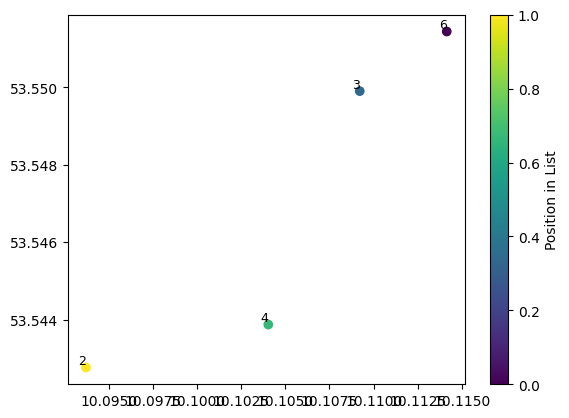

In [50]:
    
def sort_points_not_greedy(mass,D,subset): 
    closest1_avg = np.argsort(D, axis=1) #each line represents closest point indices
    # Reorder points according to closest points (second column in closest1_avg, first column points to point itself)
    sorted_idx = [subset[0]]
    print(sorted_idx)
    for idx in subset:
        if idx not in sorted_idx:
            for close_idx in closest1_avg[idx,:]:
                # print(idx,close_idx)
                if close_idx in sorted_idx:
                    sorted_idx.insert(sorted_idx.index(close_idx),idx)
                    print(sorted_idx)
                    break
    return sorted_idx

idx_sorted = sort_points_not_greedy(mass,D,subset=idx_train[:4])
cmap = cm.viridis
x=mass.get_long()[idx_sorted]
norm = plt.Normalize(0,len(x))
colors = cmap(np.linspace(0,1,num=len(x)))
scatter = plt.scatter(x,mass.get_lat()[idx_sorted], c=colors)
plt.colorbar(scatter, label='Position in List')
for i, idx in enumerate(idx_sorted):
    plt.text(x[i], mass.get_lat()[idx], str(idx), fontsize=9, ha='right', va='bottom')
# mplleaflet.display()

[np.int64(14), np.int64(6), np.int64(19), np.int64(12), np.int64(18), np.int64(17), np.int64(3), np.int64(7), np.int64(4), np.int64(8), np.int64(2)]


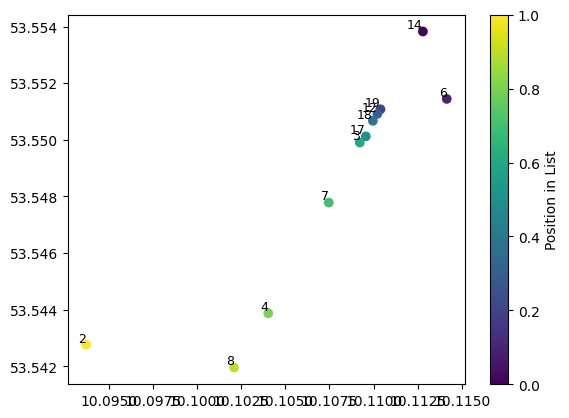

In [67]:
import itertools
def calculate_length(route,D):
    return np.sum(D[route[:-1],route[1:]])
idx_selection = idx_train[:11]
all_permutations = itertools.permutations(idx_selection)
min_cost = float('inf')
idx_sorted = None
for perm in all_permutations:
    cost = calculate_length(perm,D)
    if cost < min_cost:
        min_cost = cost
        idx_sorted = list(perm)
print(idx_sorted)
cmap = cm.viridis
x=mass.get_long()[idx_sorted]
norm = plt.Normalize(0,len(x))
colors = cmap(np.linspace(0,1,num=len(x)))
scatter = plt.scatter(x,mass.get_lat()[idx_sorted], c=colors)
plt.colorbar(scatter, label='Position in List')
for i, idx in enumerate(idx_sorted):
    plt.text(x[i], mass.get_lat()[idx], str(idx), fontsize=9, ha='right', va='bottom')
    


In [ ]:
train_positions = mass.positions[idx_train]
train_positions -= np.mean(train_positions,axis=0)
train_positions *= 1e3

In [71]:
np.savetxt('train_positions.txt',train_positions)

In [ ]:
positions_sorted = mass.positions[idx_sorted]
D_sorted =  distance.squareform(distance.pdist(positions, lambda u, v: geopy_distance.great_circle(u,v).m))

neighbor_dist = np.zeros(len(positions_sorted))

outlier_threshold = 200
plt.plot(neighbor_dist)
plt.plot([0,len(neighbor_dist)],[outlier_threshold,outlier_threshold],'r-')
idx_main_train = neighbor_dist<outlier_threshold
positions_main_train = positions_sorted[idx_main_train]

IndexError: index 95 is out of bounds for axis 0 with size 62

IndexError: boolean index did not match indexed array along axis 0; size of axis is 99 but size of corresponding boolean axis is 62

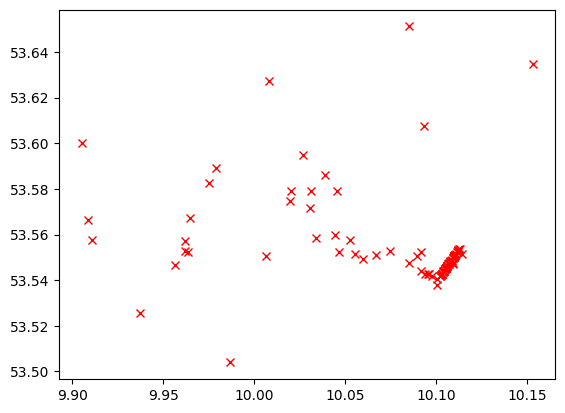

In [25]:
plt.plot(mass.get_long(),mass.get_lat(),'xr')
plt.plot(mass.get_long()[idx_main_train],mass.get_lat()[idx_main_train], 'ob', ms=3, mew=2);
mplleaflet.display()